In [1]:
import matplotlib.pyplot as plt
import re
import numpy as np

In [ ]:
# data recorded in 2 styles
from os import listdir
from os.path import isfile, join

datapath = './data'
txt_files = [f for f in listdir(datapath) if isfile(join(datapath, f)) and f[-4:] == '.txt']
style1 = [f for f in txt_files if f[:4] == 'data']
style2 = [f for f in txt_files if f[:3] == 'amp']
print(len(txt_files), len(style1), len(style2))
print(style1[0], style1[1])
print(style2[0])

In [ ]:
# rename the file
from os import rename
# style 1 with n
for filename in style1:
    segs = filename[5:-4].split('_')
    amp = int(segs[0])
    freq = int(segs[1])
    phi = int(segs[2])
    dis = int(segs[3])
    if len(segs) == 4:
        trial = 0
    else:
        try:
            trial = int(segs[4])
        except:
            trial = int(segs[4][1:])
    #print(f'{amp}_{freq}_{phi}_{dis}_{trial}')
    rename(join(datapath, filename), join(datapath, f'data_{amp}_{freq}_{phi}_{dis}_0_{trial}.txt'))

# style 2
for filename in style2:
    reg_amp = r"amp\d+\.\d+"
    reg_freq = r"freq\d+\.\d+"
    reg_phi = r"phi-*\d+\.\d+"
    reg_dist = r"dist\d+\.\d+"
    reg_trial = r"tial\d+"
    reg_turn = r"turn-*\d+"
    amp = int(float(re.findall(reg_amp, filename)[0][3:]))
    freq = int(float(re.findall(reg_freq, filename)[0][4:])*10)
    phi = int(float(re.findall(reg_phi, filename)[0][3:])*10)
    dist = int(float(re.findall(reg_dist, filename)[0][4:]))
    try:
        turn = int(re.findall(reg_turn, filename)[0][4:])
    except:
        turn = 0
    trial = int(re.findall(reg_trial, filename)[0][4:])
    rename(join(datapath, filename), join(datapath, f'data_{amp}_{freq}_{phi}_{dist}_{turn}_{trial}.txt'))

In [ ]:
txt_files = [f for f in listdir(datapath) if isfile(join(datapath, f)) and f[-4:] == '.txt' and f[:4] == 'data']
params = np.array([[int(x) for x in f.replace('.txt', '_').split('_')[1:-1]] for f in txt_files])
# amp, freq, phi, distance, turn, trial
for i in range(5, -1, -1):
    params = params[params[:, i].argsort(kind='mergesort')]  

# print(params)

key_value_idx = [0, 1, 2, 4]
def ex_key_at(p):
    return tuple([params_list[p][i] for i in key_value_idx])
params_list = params.tolist()
datas = {}
p = 0
pn = 1
consist = False
while True:
    # create the key(params): values(trial num)
    if not consist:
        datas[ex_key_at(p)] = [(params_list[p][3], params_list[p][5])]
    for i in key_value_idx: # amp, freq, phi, turn
        consist = True
        if params_list[p][i] != params_list[pn][i]:
            consist = False
            break
    if consist: 
        datas[ex_key_at(p)] = datas[ex_key_at(p)] + [(params_list[pn][3], params_list[pn][5])]
        pn += 1
    else:
        p = pn
        pn += 1
    if pn == len(params):
        break

print('key_param       ', '\t num')
for i in datas.keys():
    print(i, '  \t',len(datas[i]))

In [ ]:
params_list[-1]

In [ ]:
def get_filename(params):
    # please use datas to get the params 
    # so that it will be a file have such a name
    return 'data/data_'+'_'.join([ str(params[i]) for i in range(6)])+'.txt'

# test
get_filename(params_list[-1])

def get_params(key_params):
    other_params = datas[key_params]
    parsss = []
    for i in range(len(other_params)):
        pars = list(key_params)
        pars.insert(3, other_params[i][0])
        pars.append(other_params[i][1])
        parsss.append(pars)
    return parsss

# test
get_params((30, 8, -6, 0))

In [2]:
# old distance convetion: dist between current point and start point
filename = 'data/data_30_8_5_3_0_0.txt'
with open(filename, 'r') as file:
    file = open(filename, 'r')
    xyt = []
    traj_t = file.readlines()
regex = r"\d+\.\d+"
for ele in traj_t:
    x, y, t = re.findall(regex, ele)
    xyt.append([float(x), float(y), float(t)])
xyt = np.array(xyt)
dist = np.power((xyt - xyt[0, :]), 2)[:, :-1].sum(axis=1)

In [3]:
import matplotlib.colors as mcolors
def plot_traj_t(filename="data/data_30_10_5_30_15_1.txt", params=[30, 1.0, 0.5]):
    with open(filename, 'r') as file:
        xyt = []
        traj_t = file.readlines()
    regex = r"\d+\.\d+"
    for ele in traj_t:
        x, y, t = re.findall(regex, ele)
        xyt.append([float(x), float(y), float(t)])
    xyt = np.array(xyt)
    displace = np.roll(xyt[:, :-1], 1, axis=0)
    displace[0, :] = displace[1, :]

    delta_dist = np.power(displace - xyt[:, :-1], 2).sum(axis=1)
    # new distance convention: all summed together
    dist = np.cumsum(delta_dist)
    speed = dist / xyt[:, -1] * 1000
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))
    ax1.plot(xyt[:, 0], xyt[:, 1], alpha=0.6)

    ax1.scatter(xyt[0, 0], xyt[0, 1], color='green', label='Start')
    ax1.scatter(xyt[-1, 0], xyt[-1, 1], color='red', label='End')
    ax1.set_xlim([0, 6])
    ax1.set_ylim([0, 2])
    ax1.legend()
    ax1.set_title('Trajectory (m)')

    ax2.set_title('Average Speed (m/s)')
    ax2.plot(xyt[:, 2]/1000, speed)
    ax2.set_xlabel('Time (s)')
    plt.suptitle('$A$: {:d} $f$: {:.2f} $\phi$: {}'.format(params[0], params[1], params[2]))
    
    dt = xyt[:, -1] - np.roll(xyt[:, -1], 1, axis=0)
    dt[0] = xyt[:, -1][0]
    vel = delta_dist / dt * 1000
    ax3.set_title('Velocity (m/s)')
    ax3.plot(xyt[:, 2]/1000, vel)
    ax3.set_xlabel('Time (s)')
    
    ax1.scatter(xyt[:, 0], xyt[:, 1], c=xyt[:, 2], cmap='Set2', s=4, marker='s', label='traj w.r.t time')
    ax1.legend()
    
    plt.tight_layout()
    plt.savefig('A_{:d}_f_{:.2f}_phi_{}.pdf'.format(params[0], params[1], params[2]))

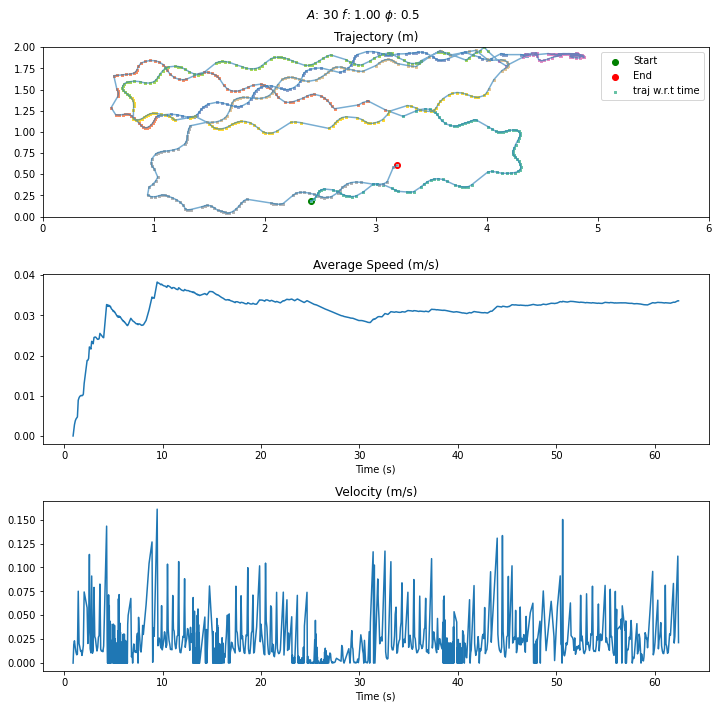

In [4]:
plot_traj_t()

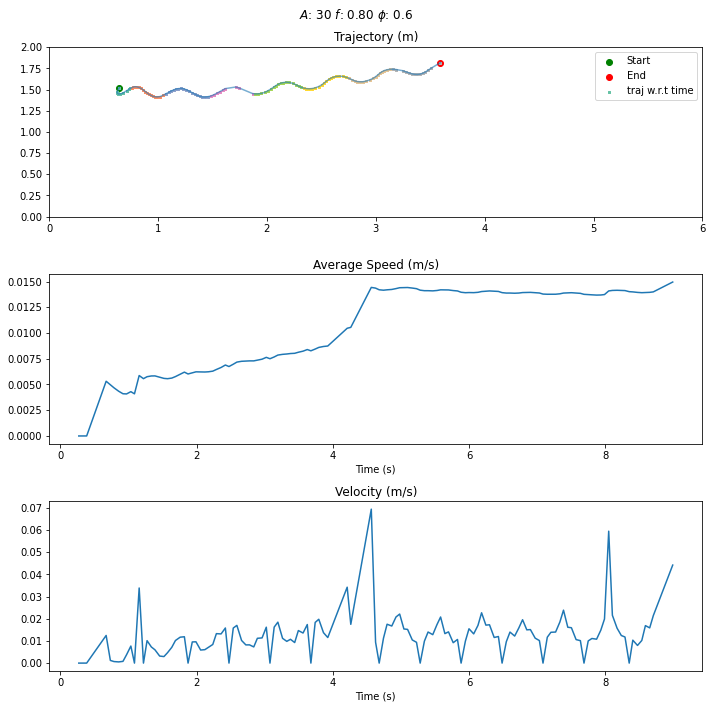

In [5]:
# Make sure the first parameter is the filename, the second is in the order of [Amplitude, frequency, phase_lag]
plot_traj_t("data/data_30_8_6_5_0_2.txt", [30, 0.8, 0.6])

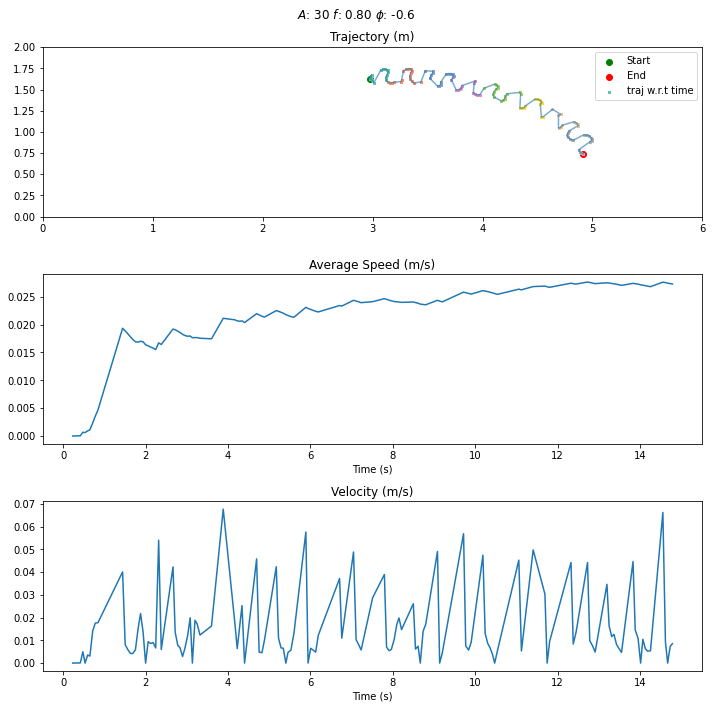

In [6]:
plot_traj_t("data/data_30_8_-6_5_0_2.txt", [30, 0.8, -0.6])

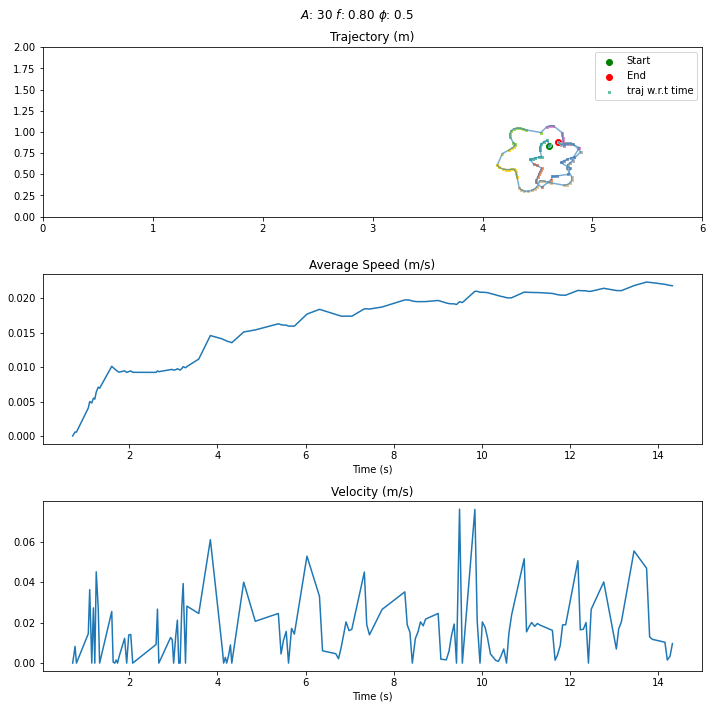

In [7]:
# Make sure the first parameter is the filename, the second is in the order of [Amplitude, frequency, phase_lag]
plot_traj_t("data/data_30_8_5_20_15_10.txt", [30, 0.8, 0.5])

In [8]:
!ls data

data_30_10_15_3_0_0.txt   data_30_8_5_20_15_5.txt  data_30_8_-6_5_0_2.txt
data_30_10_5_20_15_1.txt  data_30_8_5_20_15_6.txt  data_30_8_6_5_0_2.txt
data_30_10_5_30_15_1.txt  data_30_8_5_20_15_7.txt  data_30_8_-6_5_0_3.txt
data_30_15_15_3_0_0.txt   data_30_8_5_20_15_8.txt  data_30_8_6_5_0_3.txt
data_30_8_10_3_0_0.txt	  data_30_8_5_20_15_9.txt  data_30_8_-6_5_0_4.txt
data_30_8_10_3_0_1.txt	  data_30_8_5_3_0_0.txt    data_30_8_6_5_0_4.txt
data_30_8_10_3_0_3.txt	  data_30_8_5_3_0_1.txt    data_30_8_7_5_0_0.txt
data_30_8_10_5_0_4.txt	  data_30_8_5_3_0_2.txt    data_30_8_7_5_0_1.txt
data_30_8_15_3_0_0.txt	  data_30_8_5_3_0_3.txt    data_30_8_7_5_0_2.txt
data_30_8_15_3_0_1.txt	  data_30_8_5_3_0_4.txt    data_30_8_7_5_0_3.txt
data_30_8_15_3_0_2.txt	  data_30_8_5_5_0_1.txt    data_30_8_7_5_0_4.txt
data_30_8_5_20_15_10.txt  data_30_8_5_5_-15_1.txt  data_40_10_5_20_15_1.txt
data_30_8_5_20_15_11.txt  data_30_8_5_5_15_1.txt   data_80_8_6_5_0_10.txt
data_30_8_5_20_15_1.txt   data_30_8_6_5_0_11.txt   

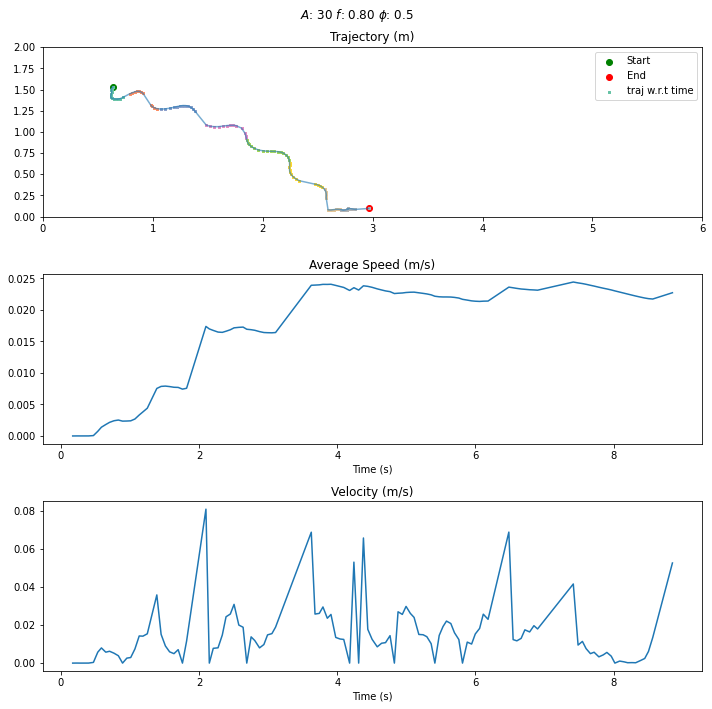

In [9]:
plot_traj_t("data/data_30_8_5_5_0_1.txt", [30, 0.8, 0.5])

### Boxplot for Experiment

In [10]:
def get_ave_speed(filename):
    with open(filename, 'r') as file:
        file = open(filename, 'r')
        xyt = []
        traj_t = file.readlines()
        regex = r"\d+\.\d+"
        for ele in traj_t:
            x, y, t = re.findall(regex, ele)
            xyt.append([float(x), float(y), float(t)])
    xyt = np.array(xyt)
    displace = np.roll(xyt[:, :-1], 1, axis=0)
    displace[0, :] = displace[1, :]

    delta_dist = np.power(displace - xyt[:, :-1], 2).sum(axis=1)
    # new distance convention: all summed together
    dist = np.cumsum(delta_dist)
    speed = dist / xyt[:, -1] * 1000
    return speed[-1]

In [11]:
get_ave_speed("data/data_30_8_5_20_15_10.txt")

0.021797712632427874

In [12]:
!ls data

data_30_10_15_3_0_0.txt   data_30_8_5_20_15_5.txt  data_30_8_-6_5_0_2.txt
data_30_10_5_20_15_1.txt  data_30_8_5_20_15_6.txt  data_30_8_6_5_0_2.txt
data_30_10_5_30_15_1.txt  data_30_8_5_20_15_7.txt  data_30_8_-6_5_0_3.txt
data_30_15_15_3_0_0.txt   data_30_8_5_20_15_8.txt  data_30_8_6_5_0_3.txt
data_30_8_10_3_0_0.txt	  data_30_8_5_20_15_9.txt  data_30_8_-6_5_0_4.txt
data_30_8_10_3_0_1.txt	  data_30_8_5_3_0_0.txt    data_30_8_6_5_0_4.txt
data_30_8_10_3_0_3.txt	  data_30_8_5_3_0_1.txt    data_30_8_7_5_0_0.txt
data_30_8_10_5_0_4.txt	  data_30_8_5_3_0_2.txt    data_30_8_7_5_0_1.txt
data_30_8_15_3_0_0.txt	  data_30_8_5_3_0_3.txt    data_30_8_7_5_0_2.txt
data_30_8_15_3_0_1.txt	  data_30_8_5_3_0_4.txt    data_30_8_7_5_0_3.txt
data_30_8_15_3_0_2.txt	  data_30_8_5_5_0_1.txt    data_30_8_7_5_0_4.txt
data_30_8_5_20_15_10.txt  data_30_8_5_5_-15_1.txt  data_40_10_5_20_15_1.txt
data_30_8_5_20_15_11.txt  data_30_8_5_5_15_1.txt   data_80_8_6_5_0_10.txt
data_30_8_5_20_15_1.txt   data_30_8_6_5_0_11.txt   

In [15]:
import glob
a30f8ph5 = glob.glob('data/data_30_8_5_3*')
a30f8ph6 = glob.glob('data/data_30_8_6_5_0_[0-9].txt')
a30f8ph7 = glob.glob('data/data_30_8_7_5_0_[0-3].txt')
a30f8ph10 = glob.glob('data/data_30_8_10_*')

In [16]:
def get_list_ave_speed(name_arr):
    ret = []
    for ele in name_arr:
        ret.append(get_ave_speed(ele))
    return np.array(ret)

In [17]:
ave5 = get_list_ave_speed(a30f8ph5)
ave6 = get_list_ave_speed(a30f8ph6)
ave7 = get_list_ave_speed(a30f8ph7)
ave10 = get_list_ave_speed(a30f8ph10)

In [18]:
def mean_std(data):
    return np.mean(data), np.std(data)

list_data = [ave5, ave6, ave7, ave10]
mean = []
std = []
for dat in list_data:
    mean.append(mean_std(dat)[0])
    std.append(mean_std(dat)[1])    

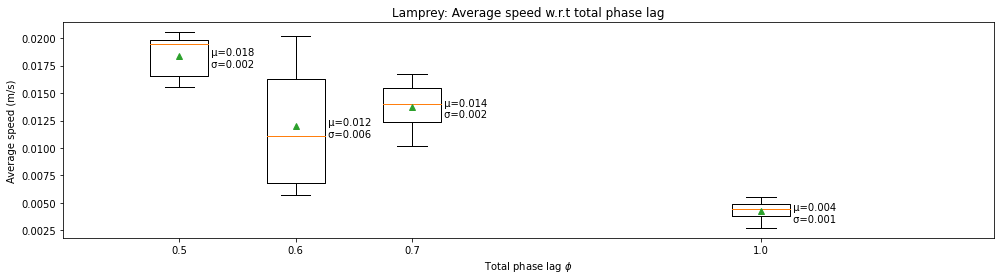

In [19]:
fig, ax = plt.subplots(figsize=(14,4))
plt.xlim([0.4, 1.2])
plt.xlabel('Total phase lag $\phi$')
plt.ylabel('Average speed (m/s)')
bp = ax.boxplot([ave5, ave6, ave7, ave10], positions=[0.5, 0.6, 0.7, 1.0], showmeans=True, widths = 0.05)

for i, line in enumerate(bp['means']):
    x, y = line.get_xydata()[0]
    text = ' μ={:.3f}\n σ={:.3f}'.format(mean[i], std[i])
    ax.annotate(text, xy=(x+0.025, y-0.001))

plt.title('Lamprey: Average speed w.r.t total phase lag')
plt.tight_layout()
fig.savefig('avg_phase.pdf')
plt.show()